In [63]:
import sys
import os
sys.path.append(os.path.abspath('..'))

# NOTE: WE ASSUME LINEAR RELATIONSHIP WE LINEAR REGRESSION

In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.cascade_property_vectorizer import get_vector_from_string

In [65]:
# Set parameters
file_path = "./data/no_padding/single/single-data-1731498761591862200.csv"
chunk_size = 1000
test_size = 0.2
random_state = 42

In [89]:
# Initialize lists for collecting data 
X_all = [] 
y_all = []  

# Read and process data in chunks 
print("Reading and processing data...") 
for chunk in pd.read_csv(file_path, chunksize=chunk_size, delimiter=";"):     
    X_chunk = np.array([get_vector_from_string(row)                         
                    for row in chunk['concatenated_bitstrings']])     
    
    # Multiply num_included and num_excluded for y_chunk
    y_chunk = (chunk['num_included'] + chunk['num_excluded']).values     
    
    X_all.append(X_chunk)     
    y_all.append(y_chunk)

Reading and processing data...


In [82]:
chunk.head()

,concatenated_bitstrings,num_included,num_excluded,duration,tries
9000,0000000000000001000001101100110000000010110000...,28626,121693,1.978853,1
9001,1100000011111000000010101111001101111000000001...,32627,89706,1.900325,1
9002,1001000010010001000010001110000010100010010000...,56587,121429,3.287367,1
9003,0000000100000000010000000011000000010000000001...,64015,73380,3.067752,1
9004,1000010000100000000000101001001010101000010110...,44936,118187,2.581045,1


In [83]:
# Create column with bitstring length
chunk['bitstring_length'] = chunk['concatenated_bitstrings'].str.len()

# Create columns with length divided by num_included and num_excluded
chunk['length_per_included'] = chunk['bitstring_length'] / chunk['num_included'] 
chunk['length_per_excluded'] = chunk['bitstring_length'] / chunk['num_excluded']
chunk['ratio'] =  (chunk['num_included'] / chunk['num_excluded'] )
chunk['filter_one_length'] = chunk['concatenated_bitstrings'].str.split(',').str[0].str.len()


# Display first few rows to verify
print("\nFirst few rows:")
print(chunk[['concatenated_bitstrings', 'bitstring_length', 'length_per_included', 'length_per_excluded', 'length_per_ratio', 'filter_one_length']].head())



First few rows:


KeyError: "['length_per_ratio'] not in index"

In [69]:
chunk.head()

,concatenated_bitstrings,num_included,num_excluded,duration,tries,bitstring_length,length_per_included,length_per_excluded,ratio,filter_one_length
9000,0000000000000001000001101100110000000010110000...,28626,121693,1.978853,1,297225,10.383043,2.442417,0.235231,127408
9001,1100000011111000000010101111001101111000000001...,32627,89706,1.900325,1,350546,10.744046,3.907721,0.363710,126752
9002,1001000010010001000010001110000010100010010000...,56587,121429,3.287367,1,243657,4.305883,2.006580,0.466009,102088
9003,0000000100000000010000000011000000010000000001...,64015,73380,3.067752,1,81444,1.272264,1.109894,0.872377,34576
9004,1000010000100000000000101001001010101000010110...,44936,118187,2.581045,1,185416,4.126224,1.568836,0.380211,74216


Text(0, 0.5, 'Count')

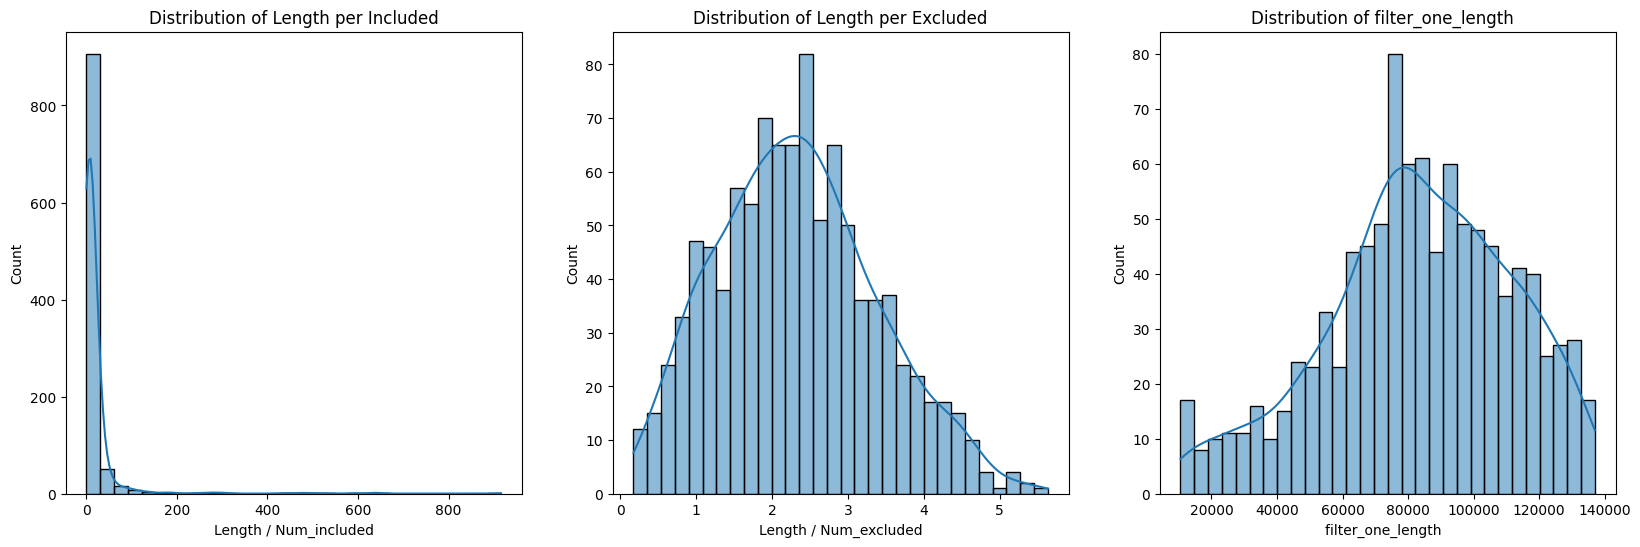

In [70]:
# Create a figure with three subplots side by side
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

# Plot histogram for length_per_included
sns.histplot(data=chunk['length_per_included'], bins=30, kde=True, ax=ax1)
ax1.set_title('Distribution of Length per Included')
ax1.set_xlabel('Length / Num_included')
ax1.set_ylabel('Count')

# Plot histogram for length_per_excluded
sns.histplot(data=chunk['length_per_excluded'], bins=30, kde=True, ax=ax2)
ax2.set_title('Distribution of Length per Excluded')
ax2.set_xlabel('Length / Num_excluded')
ax2.set_ylabel('Count')

# Plot histogram for duration
sns.histplot(data=chunk['filter_one_length'], bins=30, kde=True, ax=ax3)
ax3.set_title('Distribution of filter_one_length  ')
ax3.set_xlabel('filter_one_length  ')
ax3.set_ylabel('Count')

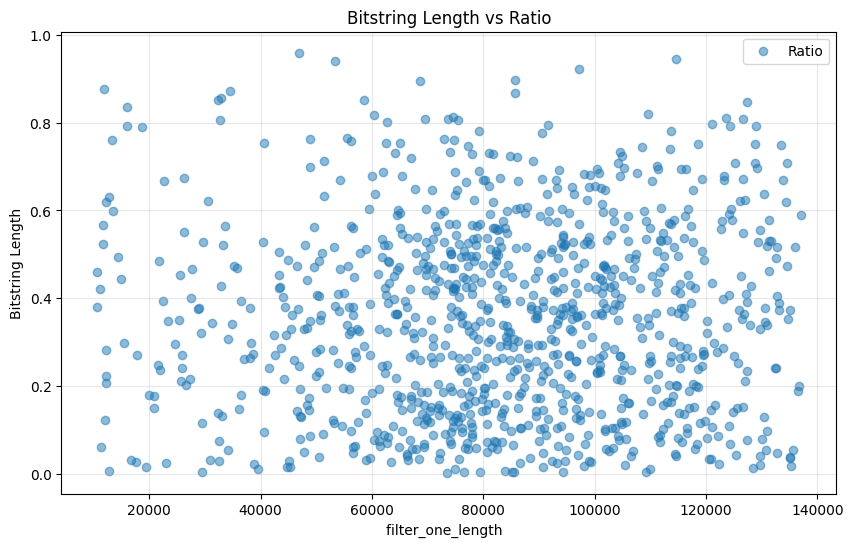

In [71]:
# Create figure
plt.figure(figsize=(10, 6))

# Create scatter plot
plt.scatter(chunk['filter_one_length'], chunk['ratio'], 
           alpha=0.5, label='Ratio')


# Customize plot
plt.title('Bitstring Length vs Ratio')
plt.xlabel('filter_one_length  ')
plt.ylabel('Bitstring Length')
plt.legend()
plt.grid(True, alpha=0.3)

<Figure size 2000x1000 with 0 Axes>

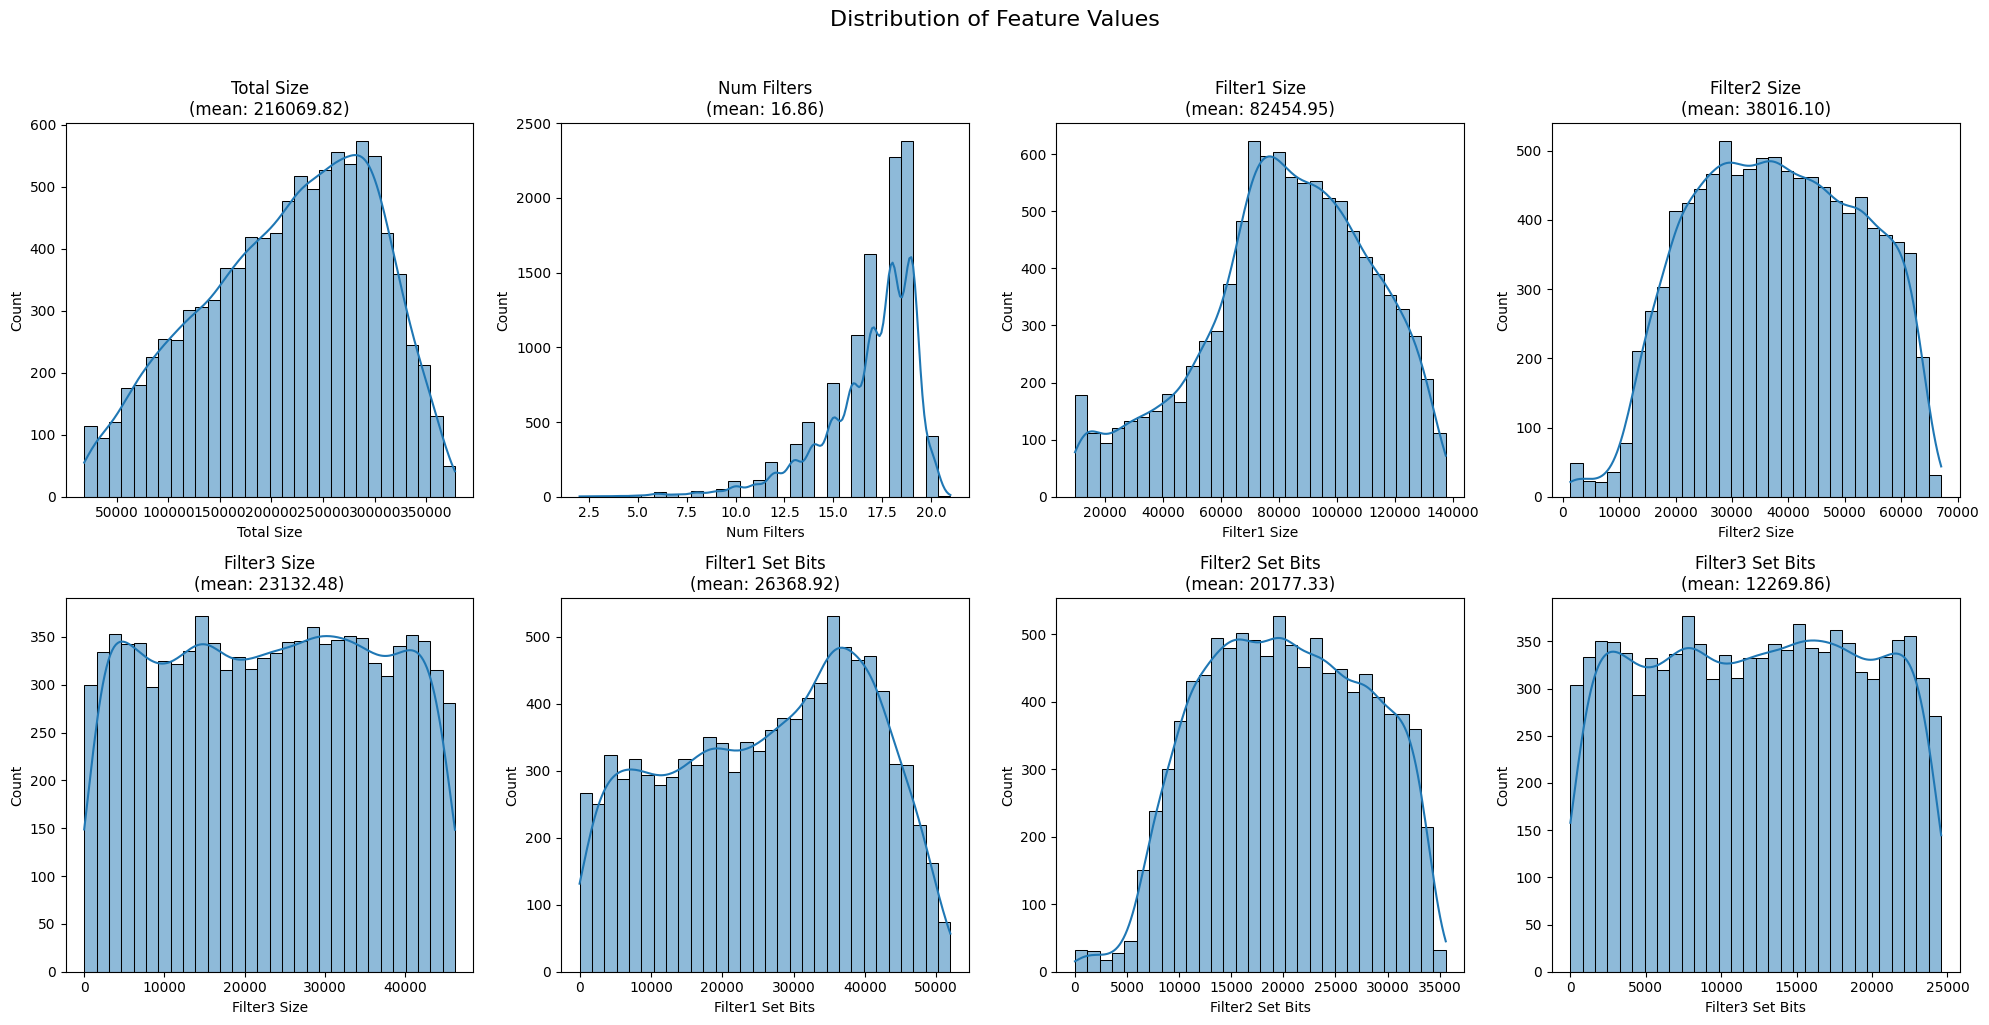

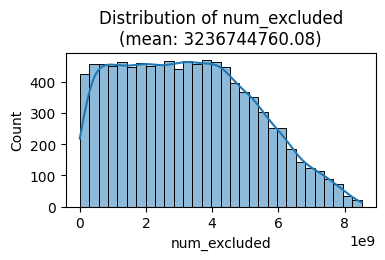

In [72]:
# Combine chunks into one array and create DataFrame
X = np.vstack(X_all)
y = np.concatenate(y_all)

feature_names = [
    'Total Size', 'Num Filters', 'Filter1 Size', 
    'Filter2 Size', 'Filter3 Size', 'Filter1 Set Bits',
    'Filter2 Set Bits', 'Filter3 Set Bits'
]
df = pd.DataFrame(X, columns=feature_names)

# Plot features
plt.figure(figsize=(20, 10))
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Distribution of Feature Values', size=16, y=1.02)

for idx, (feature, ax) in enumerate(zip(feature_names, axes.ravel())):
    sns.histplot(data=df[feature], bins=30, ax=ax, kde=True)
    ax.set_title(f'{feature}\n(mean: {df[feature].mean():.2f})')
    ax.set_ylabel('Count')

plt.tight_layout()
plt.show()

plt.figure(figsize=(4, 2))
sns.histplot(data=np.concatenate(y_all), bins=30, kde=True)
plt.title(f'Distribution of num_excluded\n(mean: {np.mean(y):.2f})')
plt.xlabel('num_excluded')
plt.ylabel('Count')
plt.show()

<Figure size 2000x1500 with 0 Axes>

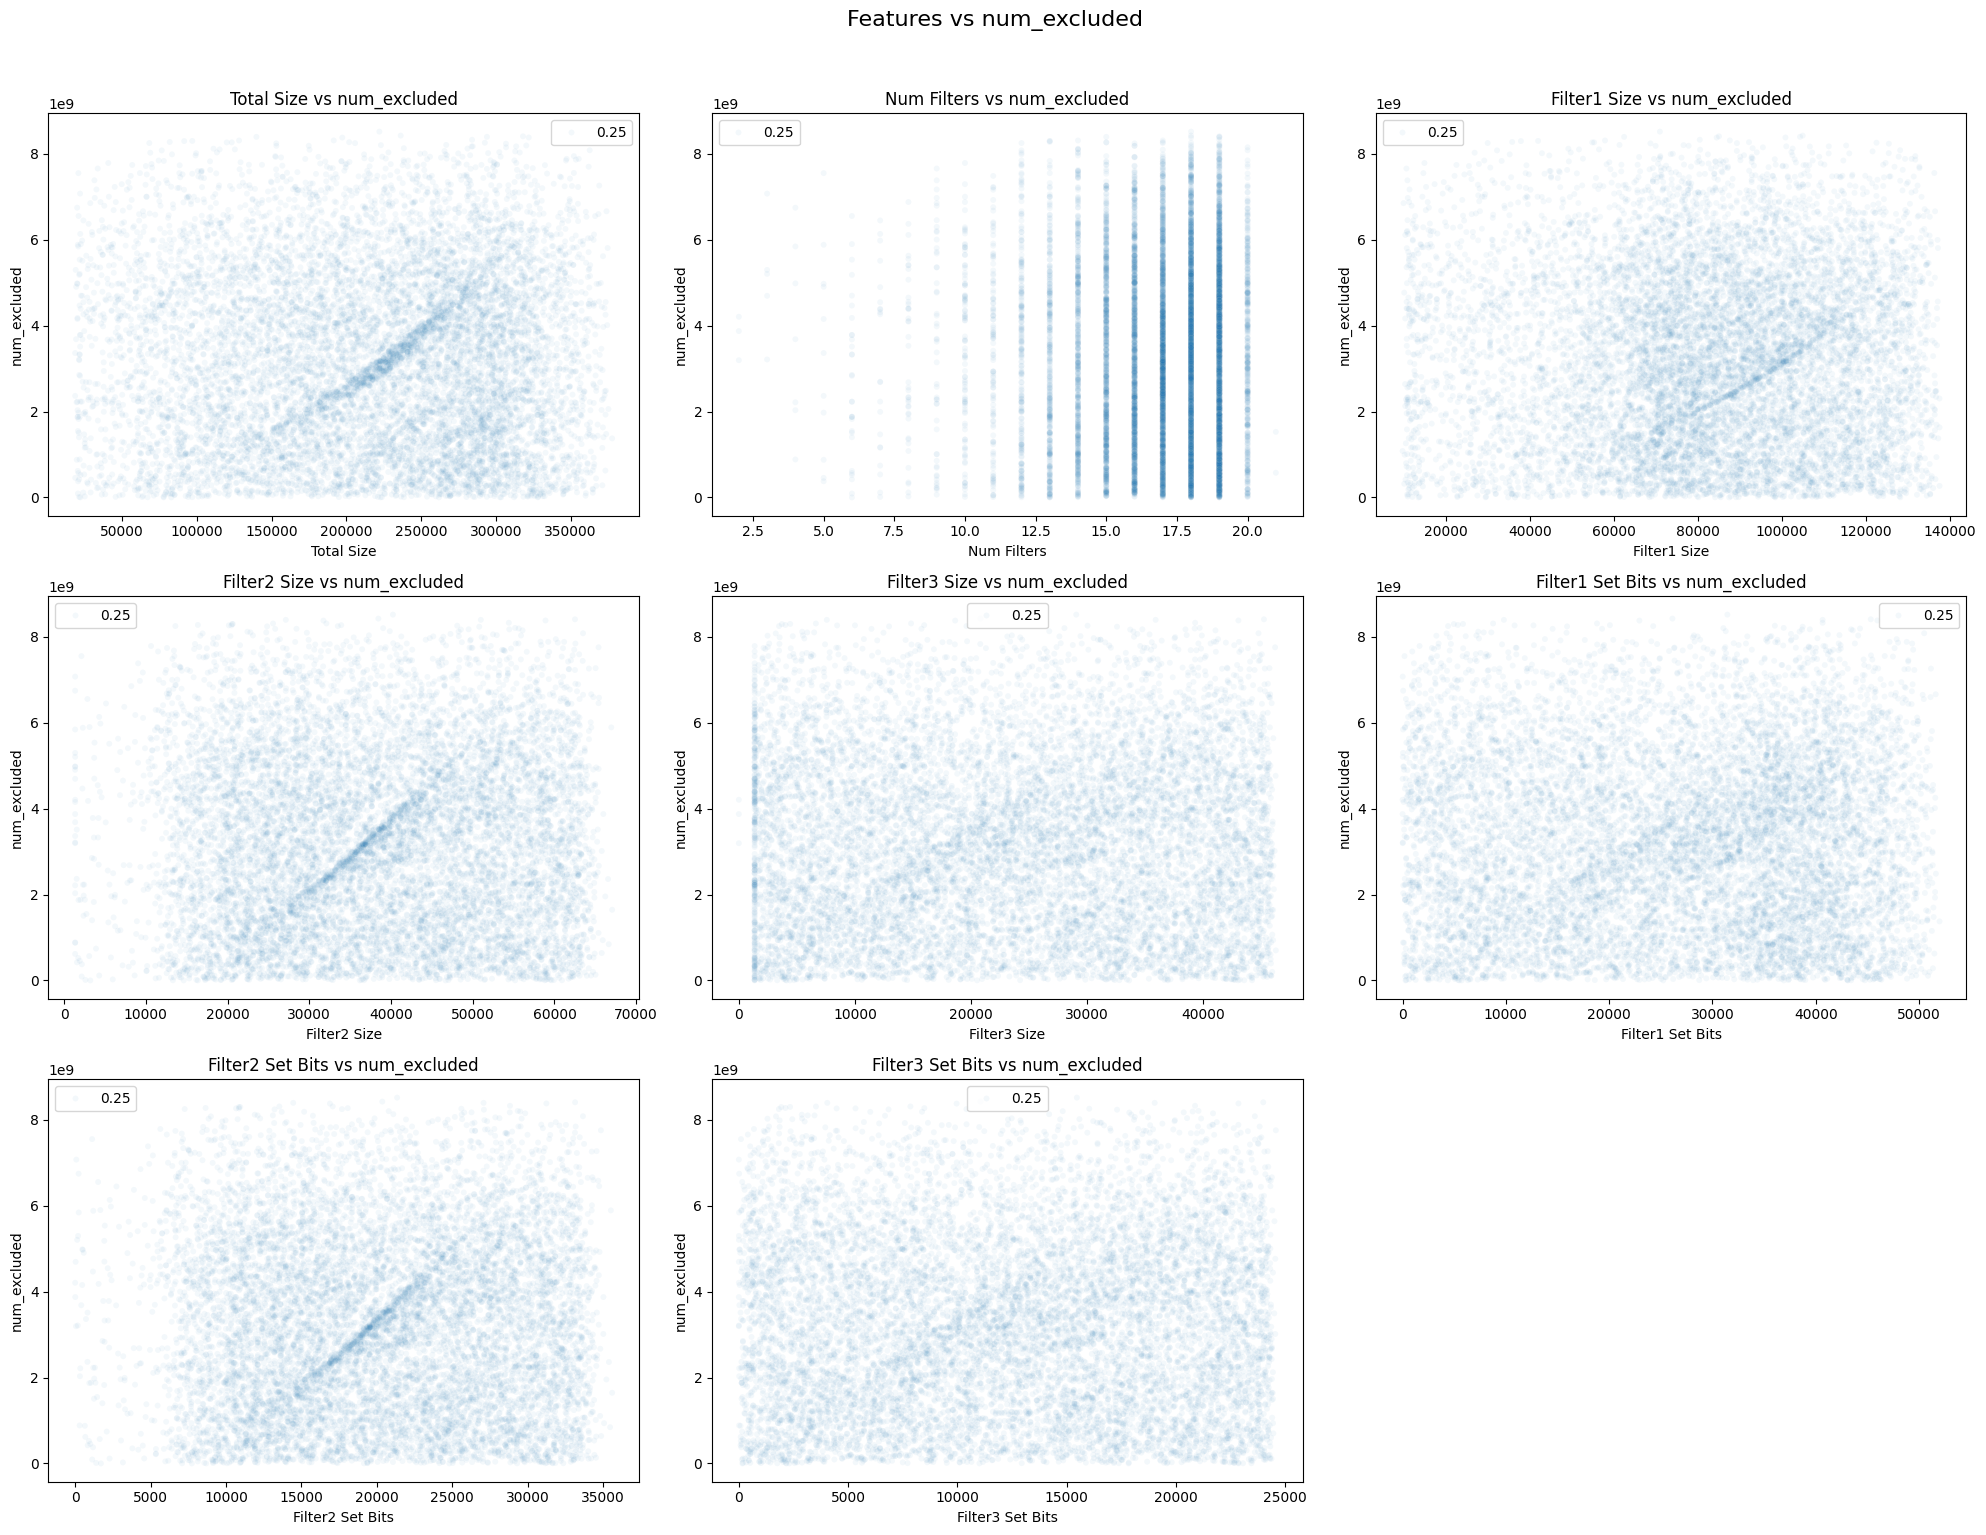

In [73]:
plt.figure(figsize=(20, 15))
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.suptitle('Features vs num_excluded', size=16, y=1.02)

# Flatten axes for easier iteration
axes = axes.ravel()

# Create scatter plot for each feature
for idx, feature in enumerate(feature_names):
    sns.scatterplot(
        data=df,
        x=feature,
        y=y,
        ax=axes[idx],
        alpha=0.05,
        size=0.25
    )
    axes[idx].set_title(f'{feature} vs num_excluded')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('num_excluded')

# Remove the empty subplot (since we have 8 features and 9 subplots)
fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

In [90]:
# Combine all chunks
X = np.vstack(X_all)
y = np.concatenate(y_all)

# Scale features
print("Scaling features...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=test_size, random_state=random_state
)

Scaling features...
Splitting data...


In [91]:
# Train linear regression model
print("Training model...")
# model = Lasso(alpha=1.0)
model = Ridge(alpha=1.0)
model.fit(X_train, y_train)

Training model...


Ridge()

In [92]:
# Make predictions
y_pred = model.predict(X_test)

In [93]:
# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance Metrics:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Model Performance Metrics:
Mean Squared Error: 753424657.09
R² Score: -0.00


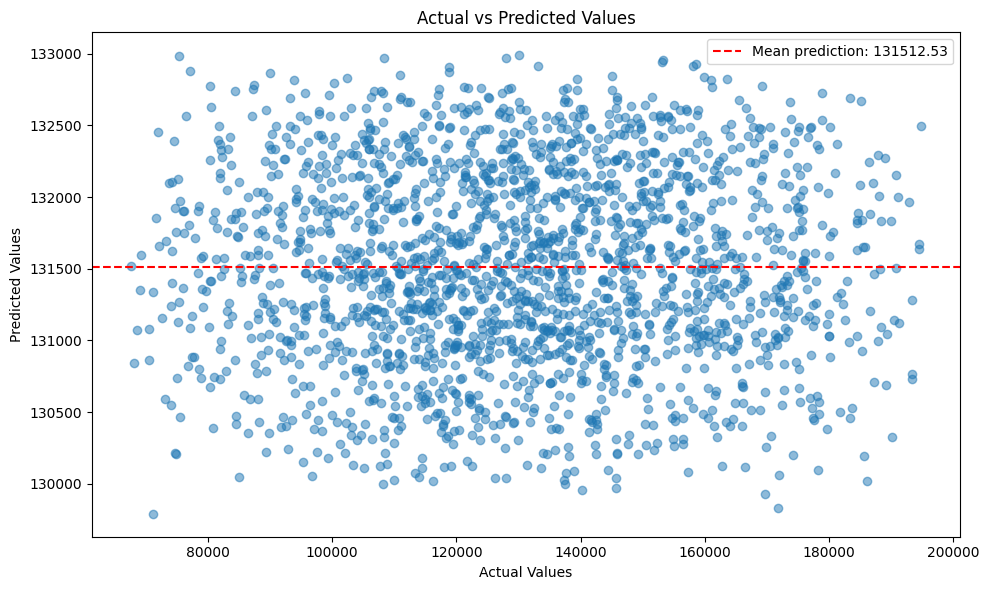

In [94]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.axhline(y=np.mean(y_pred), color='r', linestyle='--', label=f'Mean prediction: {np.mean(y_pred):.2f}')

# Set y-axis limits to the actual range of predictions
y_min, y_max = np.min(y_pred), np.max(y_pred)
plt.ylim(y_min - (y_max - y_min)*0.05, y_max + (y_max - y_min)*0.05)

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.tight_layout()
plt.show()

In [79]:
# Feature names
feature_names = [
    'Total Size', 'Num Filters', 'Filter1 Size', 
    'Filter2 Size', 'Filter3 Size', 'Filter1 Set Bits',
    'Filter2 Set Bits', 'Filter3 Set Bits'
]

# Create coefficient analysis
coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': model.coef_,
    'Abs_Coefficient': np.abs(model.coef_)
})
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

# Print coefficients
print("\nFeature Coefficients (sorted by absolute value):")
for _, row in coefficients.iterrows():
    print(f"{row['Feature']}: {row['Coefficient']:.4f}")


Feature Coefficients (sorted by absolute value):
Total Size: 926467303.5519
Filter3 Size: -511517157.7541
Filter2 Set Bits: -401181316.9320
Filter1 Size: -361982418.5816
Filter1 Set Bits: 307772157.1972
Num Filters: -65773935.3211
Filter3 Set Bits: 50678879.1039
Filter2 Size: 20406571.5014


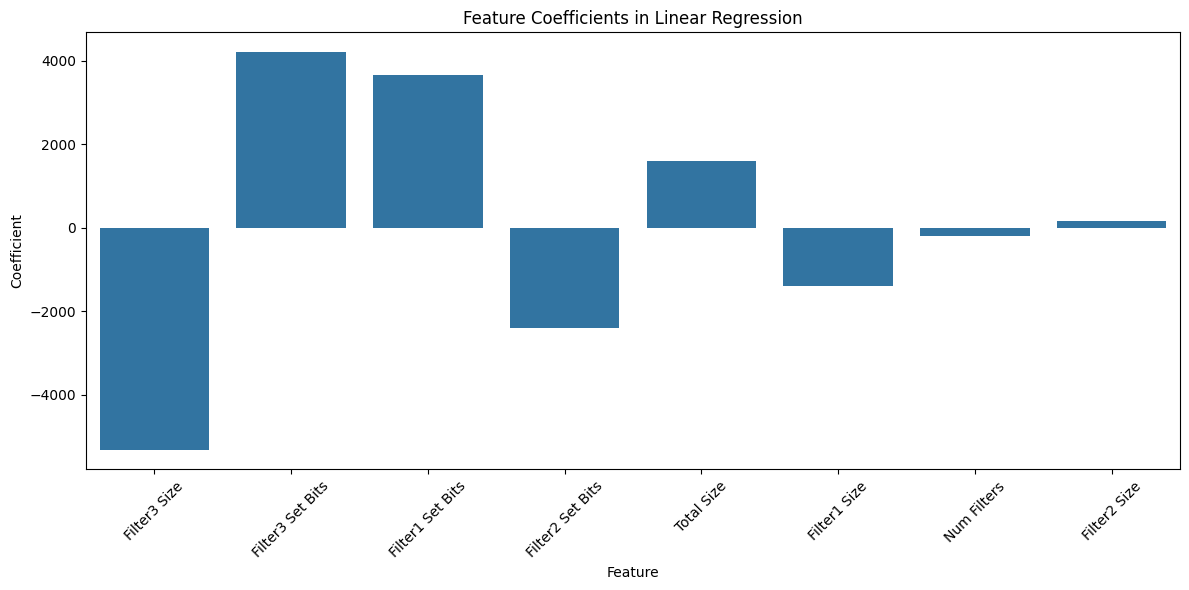

In [ ]:
# Plot coefficients
plt.figure(figsize=(12, 6))
sns.barplot(data=coefficients, x='Feature', y='Coefficient')
plt.xticks(rotation=45)
plt.title('Feature Coefficients in Linear Regression')
plt.tight_layout()
plt.show()